In [1]:
from sklearn.datasets import load_files  
import tensorflow as tf     
from keras.utils import np_utils
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image 
import random

In [2]:
# mendefinisikan fungsi untuk train, test, dan validasi dataset
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# memuat train, test, dan validasi dataset
train_files, train_targets = load_dataset('dogImages/train/')
valid_files, valid_targets = load_dataset('dogImages/valid/')
test_files, test_targets = load_dataset('dogImages/test/')

# mendefinisikan variabel untuk membuat list nama ras anjing
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistik dataset
print('Terdapat total %d kategori anjing.' % len(dog_names))
print('Terdapat total %s foto anjing.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('Terdapat total %d untuk training foto anjing.' % len(train_files))
print('Terdapat total %d untuk validation foto anjing.' % len(valid_files))
print('Terdapat total %d untuk test foto anjing.'% len(test_files))

Terdapat total 133 kategori anjing.
Terdapat total 8351 foto anjing.

Terdapat total 6680 untuk training foto anjing.
Terdapat total 835 untuk validation foto anjing.
Terdapat total 836 untuk test foto anjing.


In [3]:
def dog_class_graph(loc):
    list_names = []
    num_files = []
    dog_db = pd.DataFrame()

    for  folder in sorted(glob("dogimages/"+loc+"/*/")):
        list_names.append(folder[20:-1])
        num_files.append(len(folder))    
    dog_db['breed_name'] = list_names
    dog_db['num_images'] = num_files
    plt.figure(figsize=(20,5))
    plt.xticks(rotation=90)
    plt.bar(list_names,num_files)
    plt.show()
    return dog_db

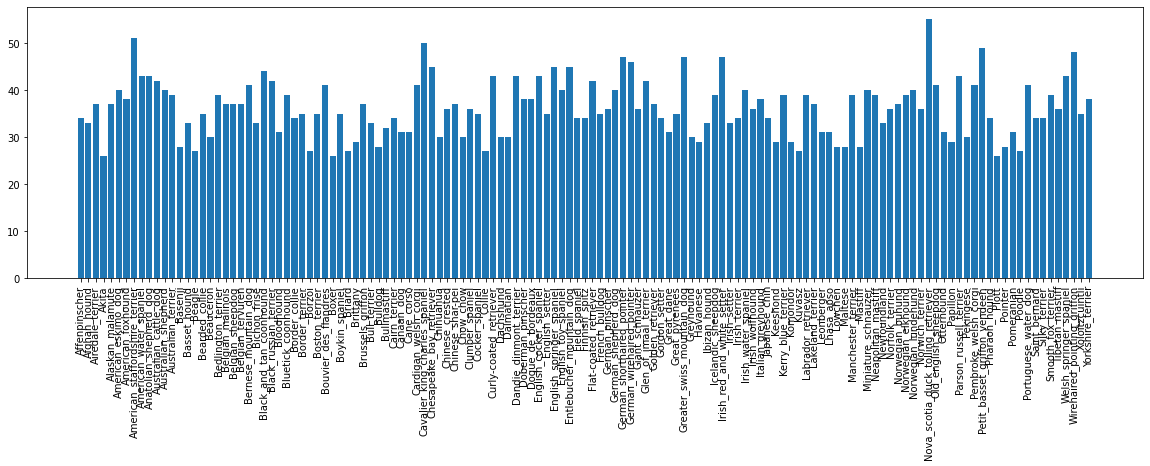

,breed_name,num_images
0,Affenpinscher,34
1,Afghan_hound,33
2,Airedale_terrier,37
3,Akita,26
4,Alaskan_malamute,37
...,...,...
128,Tibetan_mastiff,36
129,Welsh_springer_spaniel,43
130,Wirehaired_pointing_griffon,48
131,Xoloitzcuintli,35


In [4]:
dog_class_graph('train')

In [5]:
from tensorflow.keras.applications import ResNet50

# mendefinisikan model resnet50
ResNet50_model = ResNet50(weights='imagenet')

In [6]:
from tensorflow.keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    # memuat gambar rgb sebagai PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # koversi PIL.Image.Image type menjadi 3D tensor dengan bentuk (224, 224, 3)
    x = image.img_to_array(img)
    # konversi 3D tensor ke 4D tensor dengan bentuk (1, 224, 224, 3) dan mereturnkan 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [10]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # mengembalikan nilai predksi vektor untuk foto pada img_path
    img = preprocess_input(path_to_tensor(img_path))
    np.argmax(ResNet50_model.predict(img))

In [11]:
### returns "True" jika anjing terdeteksi pada gambar
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))

In [12]:
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential

Resnet50_model = Sequential()

Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dropout(0.5))
Resnet50_model.add(Dense(133, activation='softmax'))

#Resnet50_model.summary()

In [10]:
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint  

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best..hdf5', 
                               verbose=1, save_best_only=True)

history = Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=50, batch_size=20, callbacks=[checkpointer], verbose=1)

Epoch 1/50
334/334 [==============================] - 3s 7ms/step - loss: 2.3535 - accuracy: 0.4452 - val_loss: 0.9005 - val_accuracy: 0.7413

Epoch 00001: val_loss improved from inf to 0.90049, saving model to saved_models\weights.best..hdf5
Epoch 2/50
334/334 [==============================] - 2s 6ms/step - loss: 0.8057 - accuracy: 0.7485 - val_loss: 0.7240 - val_accuracy: 0.7916

Epoch 00002: val_loss improved from 0.90049 to 0.72398, saving model to saved_models\weights.best..hdf5
Epoch 3/50
334/334 [==============================] - 2s 6ms/step - loss: 0.5973 - accuracy: 0.8198 - val_loss: 0.6728 - val_accuracy: 0.7952

Epoch 00003: val_loss improved from 0.72398 to 0.67280, saving model to saved_models\weights.best..hdf5
Epoch 4/50
334/334 [==============================] - 2s 7ms/step - loss: 0.5030 - accuracy: 0.8424 - val_loss: 0.6597 - val_accuracy: 0.7988

Epoch 00004: val_loss improved from 0.67280 to 0.65973, saving model to saved_models\weights.best..hdf5
Epoch 5/50
334/3

In [11]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

In [11]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

# report test accuracy
test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy of Resnet50: %.4f%%' % test_accuracy)

Test accuracy of Resnet50: 81.1005%


In [12]:
from extract_bottleneck_features import *

def Resnet50_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = ResNet50(weights='imagenet', include_top=False).predict(preprocess_input(path_to_tensor(img_path)))
    # obtain predicted vector
    predicted_vector = Resnet50_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

In [26]:
Resnet50_predict_breed('foto/Chihuahua.jpg')
print("prediksi :", )

'Pomeranian'

In [13]:
def breed_detector(img_path):
        # dog detector achieved the best accuracy
    if dog_detector(img_path):
        print('This is a dog. I predict the breed is {}.'
            .format(Resnet50_predict_breed(img_path).split('.', 1)[0]))
    else:
        print('Error: Please input an image of a human or a dog.')

In [14]:
breed_detector('foto/baset.jpg')

This is a dog. I predict the breed is Basset_hound.
